## Лабораторна робота №4

**Тема**: Незалежне мультиагентне навчання

**Виконав:** студент групи КМ-12 Пономаренко Олександр

***Підгрупа №3***

Допустимі бібліотеки для реалізації лабораторної роботи: 
- gym, gymnasium, lbforaging – бібліотека з середовищами для навчання з 
підкріпленням; 
- tensorflow,  pytorch,  keras  –  бібліотеки  для  створення,  навчання  і 
застосування нейронних мереж; 
- numpy – бібліотека для математичних обчислень; 
- matplotlib, seaborn – бібліотеки для побудови графіків.

In [5]:
# !pip install lbforaging

In [1]:
import os
import warnings

In [7]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [46]:
import gymnasium as gym
import lbforaging
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from random import randint

In [9]:
torch._dynamo.config.suppress_errors = True
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [10]:
env = gym.make("Foraging-8x8-2p-1f-v3")

obs, info = env.reset()

for _ in range(10):
    actions = env.action_space.sample()
    obs, rewards, terminated, truncated, info = env.step(actions)
    env.render()
    time.sleep(1)
    if terminated or truncated: break

env.close()

#### 0.  Реалізувати наступні методи навчання з підкріпленням для випадку декількох агентів: 
- І підгрупа: Independent DQN 
- ІІ підгрупа: Independent REINFORCE 
- **ІІІ підгрупа: Independent A2C (без паралельних середовищ)**

Навчання та тестування агентів проводити у середовищі [LBF](https://github.com/semitable/lb-foraging). 

Можлива структура нейронної мережі для одного агента у методі IDQN:
- вхідний шар складається з $K=2$ станів $(s_t, s_{t-1}),$ першим з яких є поточний стан середовища $s_t$. Один стан $s_j$ описується картою, яка складається з $3$ бінарних матриць-шарів, кожен шар показує карту розташування об'єктів певного типу (наприклад, шар позицій їжі, шар позицій самого агента, шар позицій інших агентів). Приклад такого опису стану середовища можна знайти, зокрема, у книзі: Alexander Zai, Brandon Brown - Deep Reinforcement Learning in Action (2020), розділ 3.2.6. Також можете ознайомитись з описом середовища [LBF](https://github.com/semitable/lb-foraging) за описом у репозиторії або за статтею, посилання на яку є у репозиторії.

Набір отриманих матриць перетворюємо у вектор. Довжину цього вектора позначимо $N$. 
- Створюємо 2 прихованих шари:
    - І прихований шар має $2N$ нейронів та функцію активації ReLU;
    - ІІ прихований шар має $[\frac{3}{2}N]$ нейронів та функцію активації ReLU;
- Результатом застосування останнього прихованого шару є шар, кількість нейронів якого дорівнює кількості дій, вектор містить приблизні значення функції $Q(s_t, a).$
- Також можна запропонувати власну структуру нейронної мережі.

Для апроксимації функцій ціни стану $v(s)$ та $\pi(a|s)$ використовувати нейронні мережі.

У рамках одного агента структура нейронної мережі для функції $\pi(a|s)$ може бути такою самою, або подібною до структури мережі, яка використовувалась у ЛР2 для функції $q(s,a),$ за виключенням для останнього шару: функція активації останнього шару має задовольняти властивості функції $\pi(a|s),$ а саме: $\pi(a|s)\ge0$, $\sum_{a}\pi(a|s)=1$. Також можна запропонувати власну структуру нейронної мережі.

У рамках одного агента структура нейронної мережі для функції $v(s)$ може бути такою самою, або подібною до структури мережі, яка використовувалась у ЛР2 для функції $q(s,a)$ за виключенням для останнього шару: результатом останнього шару є лише одне значення, а не вектор значень. Також можна запропонувати власну структуру нейронної мережі.

Нейронна мережа для функції π(a|s) (policy network)

In [11]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, num_actions):
        super(PolicyNetwork, self).__init__()

        self.fc1 = nn.Linear(input_size, 2 * input_size)
        self.fc2 = nn.Linear(2 * input_size, int(1.5 * input_size))
        self.out = nn.Linear(int(1.5 * input_size), num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.out(x), dim=-1)  # Softmax для отримання π(a|s)
        return x

Нейронна мережа для функції v(s) (value network)

In [12]:
class ValueNetwork(nn.Module):
    def __init__(self, input_size):
        super(ValueNetwork, self).__init__()

        # Вхідний шар перетворення вектора стану
        self.fc1 = nn.Linear(input_size, 2 * input_size)
        self.fc2 = nn.Linear(2 * input_size, int(1.5 * input_size))
        self.out = nn.Linear(int(1.5 * input_size), 1)  # Єдине значення на виході

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)  # Лінійний вихід для v(s)
        return x

Функція для перетворення стану середовища у вектор

Стан представлений у вигляді 3-х матриць-шарів: їжа, позиція агента, позиція інших агентів

У завданні зазначено, що набір матриць потрібно перетворити у вектор

In [13]:
def preprocess_state(state):
    """
    Перетворює багатовимірний стан середовища у вектор.
    """
    return np.ravel(state)

In [14]:
env = gym.make("Foraging-8x8-2p-1f-v3")

observation, info = env.reset()

# Для простоти візьмемо стан першого агента
sample_state = preprocess_state(observation[0])
input_size = len(sample_state)
num_actions = env.action_space[0].n  # Кількість дій для одного агента

policy_net = PolicyNetwork(input_size, num_actions)
value_net = ValueNetwork(input_size)

# Перевірка роботи мереж
sample_tensor = torch.tensor(sample_state, dtype=torch.float32).unsqueeze(0)  # Додаємо batch size

policy_output = policy_net(sample_tensor)
value_output = value_net(sample_tensor)

print("Policy Output (\u03c0(a|s)):", policy_output.detach().numpy())
print("Value Output (v(s)):", value_output.detach().numpy())

env.close()

Policy Output (π(a|s)): [[0.21191177 0.13983773 0.12787825 0.16618517 0.19372602 0.16046104]]
Value Output (v(s)): [[0.06607605]]


#### 1. Провести навчання двох агентів в одному середовищі, використовуючи наступні гіперпараметри для навчання нейромереж:
- Кількість епох $Е$: будь-яке значення від $100$ до $500$;
- Кількість епізодів $М$ : будь-яке значення від $50$ до $200$.
- $\gamma = 0,99$;
- Оптимізатор цільової функції мережі - RMSProp або Adam.
- Швидкість навчання $a_w, a_{\theta}:$ будь-яке значення від $0,00001$ до $0,1$.

Після завершення навчання вивести графіки:
- для І підгрупи:
    - середньої винагороди за весь епізод у кожній епосі (тобто, графік функції $avg\_score(epoch))$;
    - середнього значення $Q(s,a)$ на валідаційному епізоді кожної епохи;
    - максимального значення функції помилки на кожній епосі;
- **для ІІ і ІІІ підгруп:**
    - **середньої винагороди за весь епізод у кожній епосі (тобто, графік функції $avg\_score(epoch))$;**
    - **середнього значення $G_t - v(s)$ на валідаційному епізоді кожної епохи;**
    - **максимального значення функції $G_t - v(s)$ на кожній епосі;**

*Валідаційний епізод (held-out set) - це епізод, який відбуваєтсья після завершення однієї епохи навчання.*

In [35]:
def train_agents(env_name="Foraging-8x8-2p-1f-v3", epochs=100, episodes=100, gamma=0.99, lr_policy=0.0001, lr_value=0.0001):
    env = gym.make(env_name)
    observation, info = env.reset()

    num_agents = len(observation)
    input_size = len(preprocess_state(observation[0]))
    num_actions = env.action_space[0].n

    policy_nets = [PolicyNetwork(input_size, num_actions) for _ in range(num_agents)]
    value_nets = [ValueNetwork(input_size) for _ in range(num_agents)]

    policy_optimizers = [optim.Adam(net.parameters(), lr=lr_policy) for net in policy_nets]
    value_optimizers = [optim.Adam(net.parameters(), lr=lr_value) for net in value_nets]

    avg_scores = []
    avg_advantages = []
    max_advantages = []

    for epoch in range(epochs):
        epoch_rewards = []
        epoch_advantages = []

        for _ in range(episodes):
            observation, info = env.reset()
            rewards = [0 for _ in range(num_agents)]
            states, actions, log_probs, values = [[] for _ in range(num_agents)], [[] for _ in range(num_agents)], [[] for _ in range(num_agents)], [[] for _ in range(num_agents)]

            terminated, truncated = False, False
            while not (terminated or truncated):
                for agent_idx in range(num_agents):
                    state = preprocess_state(observation[agent_idx])
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

                    policy = policy_nets[agent_idx](state_tensor)
                    value = value_nets[agent_idx](state_tensor)

                    action = torch.multinomial(policy, 1).item()
                    log_prob = torch.log(policy[0, action])

                    states[agent_idx].append(state)
                    actions[agent_idx].append(action)
                    log_probs[agent_idx].append(log_prob)
                    values[agent_idx].append(value)

                actions_sampled = [actions[agent_idx][-1] for agent_idx in range(num_agents)]
                observation, step_rewards, terminated, truncated, info = env.step(actions_sampled)

                for agent_idx in range(num_agents):
                    rewards[agent_idx] += step_rewards[agent_idx]

            epoch_rewards.append(np.mean(rewards))

            for agent_idx in range(num_agents):
                G = 0
                returns, advantages = [], []

                for t in reversed(range(len(states[agent_idx]))):
                    G = rewards[agent_idx] + gamma * G
                    returns.insert(0, G)

                returns = torch.tensor(returns, dtype=torch.float32)
                values_tensor = torch.cat(values[agent_idx])
                advantages = returns - values_tensor.detach()

                epoch_advantages.append(advantages.mean().item())

                policy_loss = -torch.mean(torch.stack([log_prob * advantage for log_prob, advantage in zip(log_probs[agent_idx], advantages)]))
                value_loss = torch.mean((values_tensor - returns) ** 2)

                policy_optimizers[agent_idx].zero_grad()
                policy_loss.backward()
                policy_optimizers[agent_idx].step()

                value_optimizers[agent_idx].zero_grad()
                value_loss.backward()
                value_optimizers[agent_idx].step()

        observation, info = env.reset()
        rewards = [0 for _ in range(num_agents)]
        states, values = [[] for _ in range(num_agents)], [[] for _ in range(num_agents)]

        terminated, truncated = False, False
        while not (terminated or truncated):
            for agent_idx in range(num_agents):
                state = preprocess_state(observation[agent_idx])
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

                value = value_nets[agent_idx](state_tensor)
                states[agent_idx].append(state)
                values[agent_idx].append(value)

            actions_sampled = [env.action_space[agent_idx].sample() for agent_idx in range(num_agents)]
            observation, step_rewards, terminated, truncated, info = env.step(actions_sampled)

            for agent_idx in range(num_agents):
                rewards[agent_idx] += step_rewards[agent_idx]

        validation_advantages = []
        for agent_idx in range(num_agents):
            returns = []
            G = 0
            for t in reversed(range(len(states[agent_idx]))):
                G = rewards[agent_idx] + gamma * G
                returns.insert(0, G)

            returns = torch.tensor(returns, dtype=torch.float32)
            values_tensor = torch.cat(values[agent_idx])
            advantages = returns - values_tensor.detach()

            validation_advantages.append(advantages.mean().item())

        avg_advantages.append(np.mean(validation_advantages))
        max_advantages.append(np.max(validation_advantages))

        avg_scores.append(np.mean(epoch_rewards))

        print(f"Epoch {epoch + 1}/{epochs}  Average Reward: {avg_scores[-1]:.2f}  "
              f"Average Advantage (Validation): {avg_advantages[-1]:.2f}  Max Advantage (Training): {max_advantages[-1]:.2f}")

    for agent_idx in range(num_agents):
        torch.save(policy_nets[agent_idx].state_dict(), f"policy_net_agent_{agent_idx}.pth")
        torch.save(value_nets[agent_idx].state_dict(), f"value_net_agent_{agent_idx}.pth")
    
    env.close()

    plt.figure()
    plt.plot(range(epochs), avg_scores, label='Average Reward')
    plt.title('Average Reward per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(range(epochs), avg_advantages, label='Average Validation Advantage', color='orange')
    plt.title('Average Advantage per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Advantage')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(range(epochs), max_advantages, label='Maximum Training Advantage', color='green')
    plt.title('Maximum Advantage per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Advantage')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/100  Average Reward: 0.12  Average Advantage (Validation): -0.20  Max Advantage (Training): -0.17
Epoch 2/100  Average Reward: 0.12  Average Advantage (Validation): -0.32  Max Advantage (Training): -0.30
Epoch 3/100  Average Reward: 0.12  Average Advantage (Validation): -0.46  Max Advantage (Training): -0.43
Epoch 4/100  Average Reward: 0.15  Average Advantage (Validation): -0.45  Max Advantage (Training): -0.35
Epoch 5/100  Average Reward: 0.14  Average Advantage (Validation): -0.63  Max Advantage (Training): -0.53
Epoch 6/100  Average Reward: 0.14  Average Advantage (Validation): -0.67  Max Advantage (Training): -0.56
Epoch 7/100  Average Reward: 0.13  Average Advantage (Validation): -0.95  Max Advantage (Training): -0.75
Epoch 8/100  Average Reward: 0.12  Average Advantage (Validation): -0.51  Max Advantage (Training): -0.39
Epoch 9/100  Average Reward: 0.13  Average Advantage (Validation): -0.72  Max Advantage (Training): -0.70
Epoch 10/100  Average Reward: 0.13  Average Ad

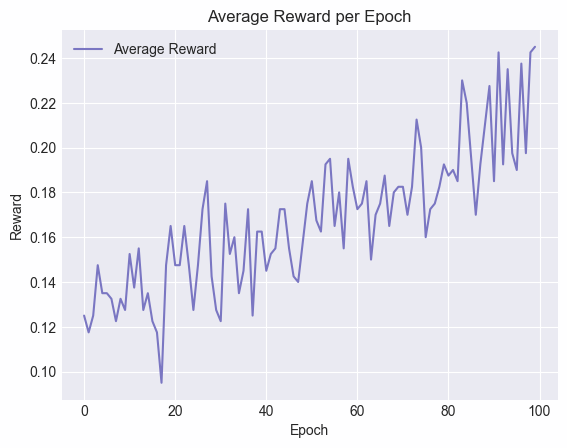

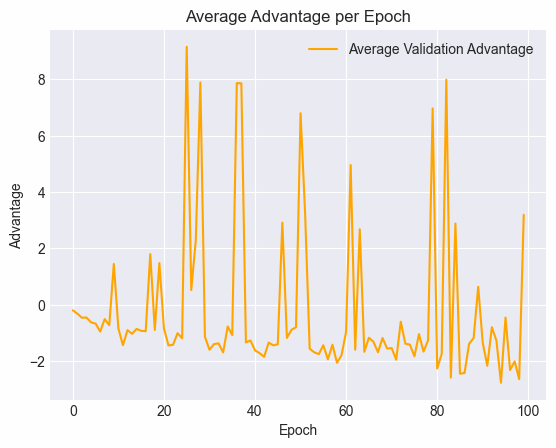

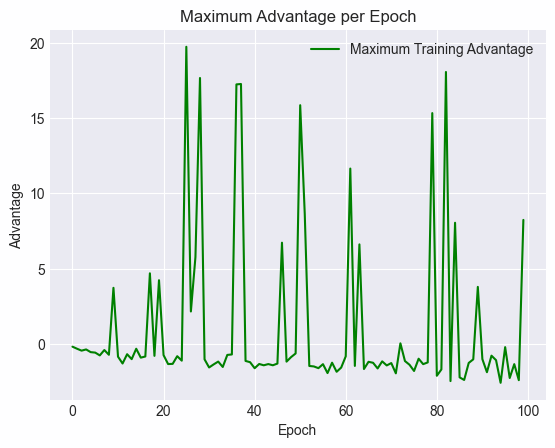

In [49]:
train_agents(
    epochs=100,
    episodes=200,
    gamma=0.99,
    lr_policy=0.0001,
    lr_value=0.0001
)

#### 2. Провести тестування кожного агента в одному середовищі, запустивши 100 епізодів. Виведіть на екран два графіки: винагорода та тривалість епізоду. Також для епізодів $№№$ $1$, $randint(1, 100)$ та $100$ виведіть графік винагороди $(score)$, отриманої на кожному кроці епізоду. Зробіть висновки.

In [50]:
def test_agents(env_name="Foraging-8x8-2p-1f-v3", episodes=100):
    env = gym.make(env_name)
    observation, info = env.reset()

    num_agents = len(observation)
    policy_nets = []

    # Load saved models
    for agent_idx in range(num_agents):
        policy_net = PolicyNetwork(len(preprocess_state(observation[0])), env.action_space[0].n)
        policy_net.load_state_dict(torch.load(f"policy_net_agent_{agent_idx}.pth", weights_only=True))
        policy_net.eval()
        policy_nets.append(policy_net)

    rewards_per_episode = []
    durations_per_episode = []
    step_rewards = []

    for episode in range(episodes):
        observation, info = env.reset()
        rewards = [0 for _ in range(num_agents)]
        step_rewards_episode = []
        terminated, truncated = False, False
        steps = 0

        while not (terminated or truncated):
            actions = []

            for agent_idx in range(num_agents):
                state = preprocess_state(observation[agent_idx])
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

                policy = policy_nets[agent_idx](state_tensor)
                action = torch.multinomial(policy, 1).item()
                actions.append(action)

            observation, step_reward, terminated, truncated, info = env.step(actions)
            for agent_idx in range(num_agents):
                rewards[agent_idx] += step_reward[agent_idx]

            step_rewards_episode.append(np.mean(step_reward))
            steps += 1

        rewards_per_episode.append(np.mean(rewards))
        durations_per_episode.append(steps)
        step_rewards.append(step_rewards_episode)

    env.close()

    # Plot rewards and durations per episode
    plt.figure()
    plt.plot(range(episodes), rewards_per_episode, label='Rewards per Episode')
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(range(episodes), durations_per_episode, label='Duration per Episode', color='orange')
    plt.title('Duration per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Duration (steps)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Select episodes to plot step rewards
    selected_episodes = [1, randint(1, 100), 100]

    for episode in selected_episodes:
        plt.figure()
        plt.plot(range(len(step_rewards[episode - 1])), step_rewards[episode - 1], label=f'Episode {episode}')
        plt.title(f'Rewards per Step in Episode {episode}')
        plt.xlabel('Step')
        plt.ylabel('Reward')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Summary of results
    print(f"Average reward across episodes: {np.mean(rewards_per_episode):.2f}")
    print(f"Average duration across episodes: {np.mean(durations_per_episode):.2f} steps")

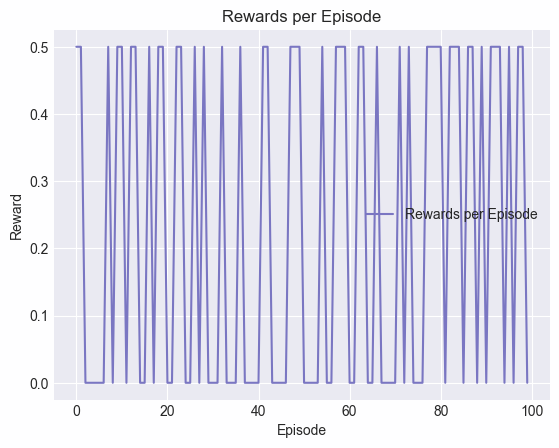

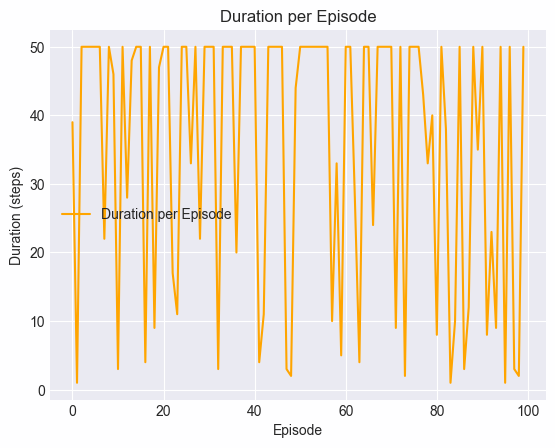

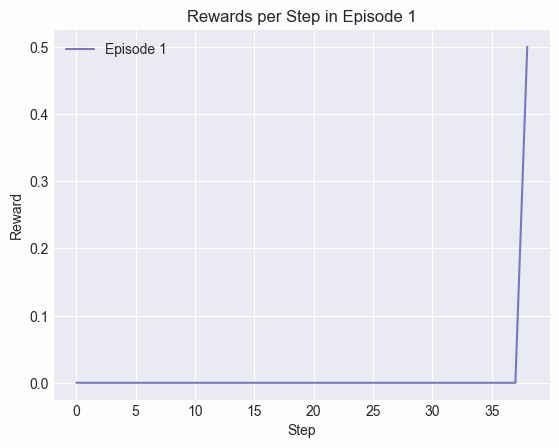

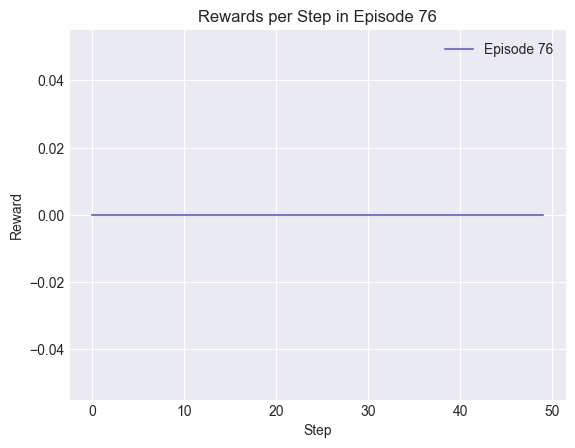

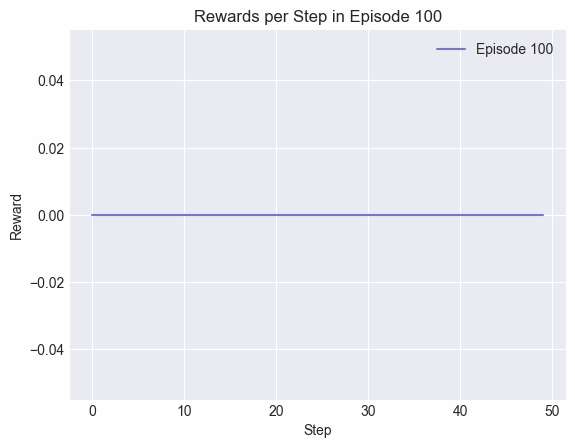

Average reward across episodes: 0.23
Average duration across episodes: 35.51 steps


In [51]:
test_agents()